In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Subset
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")




Using cuda device


In [3]:
file_path = r"C:\Users\valdi\OneDrive\Desktop\Phys 361\ML Project\Data\Testing\Simulated_Test_Data\noise_0_device_7_file_008.npy"


sample = np.load(file_path, allow_pickle=True).item()

sensor = sample['sensor']
label = sample['label']

sensor.shape

sensor = torch.tensor(sensor, dtype=torch.float32).view(-1)

sensor.view(-1).shape

torch.Size([900])

In [4]:
class DNN_Data(torch.utils.data.Dataset):
    """
    Dataset class for fully connected DNN training on quantum dot sensor data.
    """

    def __init__(self, data_file, label_map, num_points=150000, transform=None, target_transform=None, norm_method=None):
        self.data_files = data_file
        self.files = [f for f in os.listdir(data_file) if f.endswith('.npy')]
        if num_points < len(self.files):
            self.files = np.random.choice(self.files, size=num_points, replace=False)
        self.label_map = label_map
        self.transform = transform
        self.target_transform = target_transform
        self.norm_method = norm_method

        # Precomputed from training data
        self.mean = -0.02983519289686415
        self.std = 0.9185856299380564
        self.min = -1.5295182466506958
        self.max = 5.044922351837158

    def __len__(self):
        return len(self.files)
    
    def normalize(self, arr):
        if self.norm_method == "zscore":
            return (arr - self.mean) / self.std
        elif self.norm_method == "minmax":
            return (arr - self.min) / (self.max - self.min)
        elif self.norm_method == "unit":
            norm = np.linalg.norm(arr)
            return arr / norm if norm > 0 else arr
        else:
            return arr

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_files, self.files[idx])
        sample = np.load(file_path, allow_pickle=True).item()

        sensor = sample['sensor']  # shape (30, 30)
        labels = sample['label']  # shape (30, 30)

        sensor = sensor.flatten()
        sensor = self.normalize(sensor)
        sensor = torch.tensor(sensor, dtype=torch.float32)

        label = np.zeros(len(self.label_map))
        for i, key in enumerate(self.label_map.keys()):
            label[i] = np.sum(labels == key) / (labels.shape[0] ** 2)
        label = torch.tensor(label, dtype=torch.float32)

        return sensor, label


In [ ]:
class DNNModel(nn.Module):
    def __init__(self, input_dim=900, output_dim=5):
        super(DNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, output_dim),
            nn.Softmax(dim=1)
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)


In [6]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    total_mse = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) 

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            correct, samples = calculate_accuracy(outputs, labels)
            total_correct += correct
            total_samples += samples

            probs = torch.nn.functional.softmax(outputs, dim=1)
            mse = torch.nn.functional.mse_loss(probs, labels)
            total_mse += mse.item() * samples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    mse_accuracy = total_mse / total_samples

    return avg_loss, accuracy, mse_accuracy

def calculate_accuracy(outputs, labels):
    """Accuracy as exact match between predicted and argmax of soft label."""
    preds = torch.argmax(outputs, dim=1)
    true = torch.argmax(labels, dim=1)

    correct = (preds == true).sum().item()
    total = labels.size(0)
    return correct, total


In [ ]:
label_map = {
    0: 'No Dot',
    0.5: 'Left Dot',
    1: 'Central Dot',
    1.5: 'Right Dot',
    2: 'Double Dot'
}

num_points = 150000
batch_size = 128

data_file_train = "Data\\Training\\Simulated_Train_Data\\Simulated_Train_Data"
data_file_test = "Data\\Testing\\Simulated_Test_Data"

train_dataset = DNN_Data(data_file_train, label_map, num_points=num_points, norm_method="zscore")
test_dataset = DNN_Data(data_file_test, label_map, num_points=num_points, norm_method="zscore")

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataset_size = len(train_dataset)
all_indices = np.arange(dataset_size)
np.random.seed(42)
np.random.shuffle(all_indices)
ratios = [0.9]
results = {}

for ratio in ratios:
    train_size = int(ratio * dataset_size)
    train_indices = all_indices[:train_size]
    val_indices = all_indices[train_size:]

    train_split = Subset(train_dataset, train_indices)
    val_split = Subset(train_dataset, val_indices)

    
    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)
    num_epochs = 50

    model = DNNModel(input_dim=900, output_dim=5).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    performance_log = {
        'train_accuracy': [],
        'train_mse_accuracy': [],
        'val_accuracy': [],
        'val_mse_accuracy': [],
        'test_accuracy': [],
        'test_mse_accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'test_loss': []
    }

    for epoch in range(num_epochs):

        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        print(f"Done with epoch {epoch}")

        for batch_inputs, batch_targets in train_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            predictions = model(batch_inputs)
            
            #print(predictions.shape, batch_targets.shape)
            loss = criterion(predictions, batch_targets)
            #print(loss.device())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

            #print(batch_inputs.device, batch_targets.device, next(model.parameters()).device)
            #print(f"predictions device: {predictions.device}")
        
        train_loss, train_acc, train_mse_acc = evaluate(model, train_loader, criterion)
        performance_log['train_loss'].append(train_loss)
        performance_log['train_accuracy'].append(train_acc)
        performance_log['train_mse_accuracy'].append(train_mse_acc)

    
        val_loss, val_acc, val_mse_acc = evaluate(model, val_loader, criterion)
        performance_log['val_loss'].append(val_loss)
        performance_log['val_accuracy'].append(val_acc)
        performance_log['val_mse_accuracy'].append(val_mse_acc)

    
    test_loss, test_acc, test_mse_acc = evaluate(model, test_dataloader, criterion)
    performance_log['test_loss'].append(test_loss)
    performance_log['test_accuracy'].append(test_acc)
    performance_log['test_mse_accuracy'].append(test_mse_acc)


    torch.save(model.state_dict(), f"DNN_model_epoch_{num_epochs}.pth")

    max_length = max(len(v) for v in performance_log.values())
    for key in performance_log:
        if len(performance_log[key]) < max_length:
            performance_log[key] += [np.nan] * (max_length - len(performance_log[key]))

    metrics_df = pd.DataFrame(performance_log)
    metrics_df.to_csv(f"DNN_metrics_epoch_{num_epochs}.csv", index=False)

    print("Training is done")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test MSE Accuracy: {test_mse_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")


Epoch 1/30
Done with epoch 0
Epoch 2/30
Done with epoch 1
Epoch 3/30
Done with epoch 2
Epoch 4/30
Done with epoch 3
Epoch 5/30
Done with epoch 4
Epoch 6/30
Done with epoch 5
Epoch 7/30
Done with epoch 6
Epoch 8/30
Done with epoch 7
Epoch 9/30
Done with epoch 8
Epoch 10/30
Done with epoch 9
Epoch 11/30
Done with epoch 10
Epoch 12/30
Done with epoch 11
Epoch 13/30
Done with epoch 12
Epoch 14/30
Done with epoch 13
Epoch 15/30
Done with epoch 14
Epoch 16/30
Done with epoch 15
Epoch 17/30
Done with epoch 16
Epoch 18/30
Done with epoch 17
Epoch 19/30
Done with epoch 18
Epoch 20/30
Done with epoch 19
Epoch 21/30
Done with epoch 20
Epoch 22/30
Done with epoch 21
Epoch 23/30
Done with epoch 22
Epoch 24/30
Done with epoch 23
Epoch 25/30
Done with epoch 24
Epoch 26/30
Done with epoch 25
Epoch 27/30
Done with epoch 26
Epoch 28/30
Done with epoch 27
Epoch 29/30
Done with epoch 28
Epoch 30/30
Done with epoch 29
Training is done
Test Accuracy: 0.9417
Test MSE Accuracy: 0.0766
Test Loss: 0.0087


Test Accuracy:  0.9398989898989899
Test MSE Loss:  0.07625102240479353
Test MSE Accuracy:  0.9237489775952065
Test Loss:  0.008096971485594457


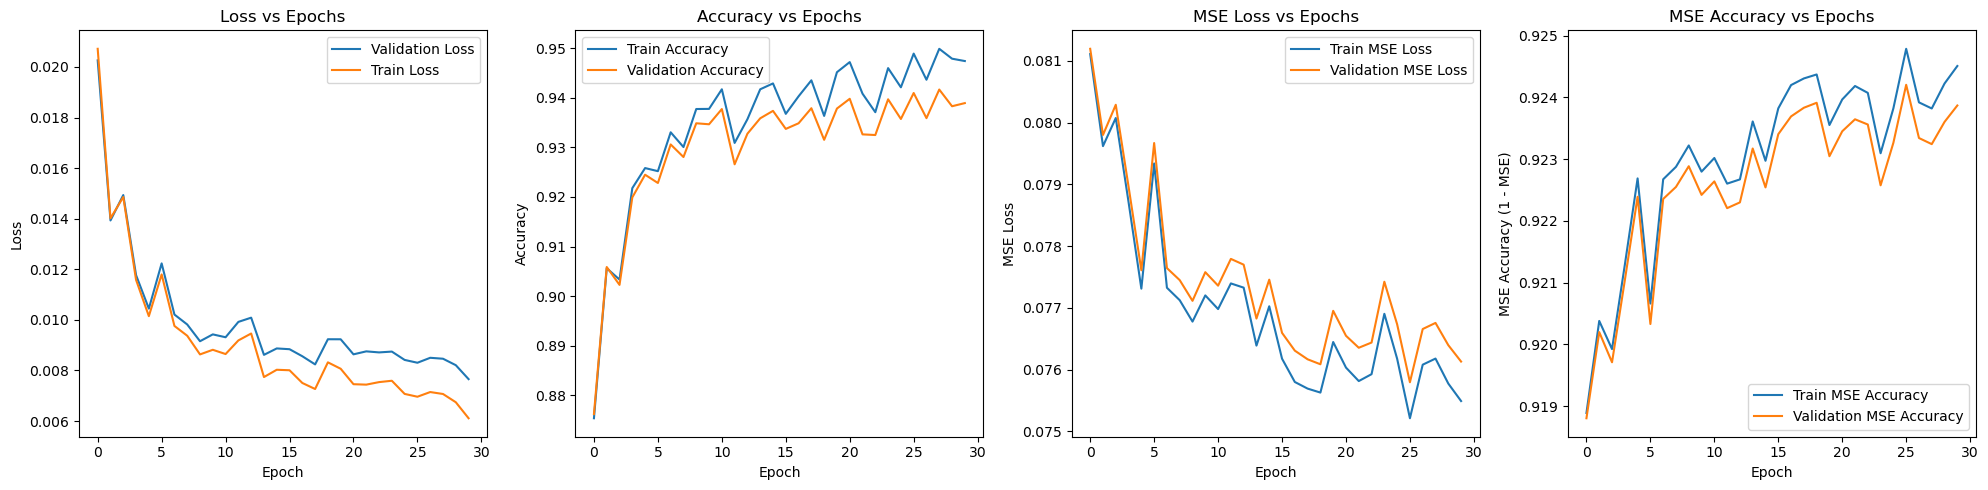

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].plot(performance_log['val_loss'], label="Validation Loss")
ax[0].plot(performance_log['train_loss'], label="Train Loss")
ax[0].set_title("Loss vs Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()


ax[1].plot(performance_log['train_accuracy'], label="Train Accuracy")
ax[1].plot(performance_log['val_accuracy'], label="Validation Accuracy")
ax[1].set_title("Accuracy vs Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()


ax[2].plot(performance_log['train_mse_accuracy'], label="Train MSE Loss")
ax[2].plot(performance_log['val_mse_accuracy'], label="Validation MSE Loss")
ax[2].set_title("MSE Loss vs Epochs")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("MSE Loss")
ax[2].legend()

train_mse_acc = [1 - v for v in performance_log['train_mse_accuracy']]
val_mse_acc = [1 - v for v in performance_log['val_mse_accuracy']]

ax[3].plot(train_mse_acc, label="Train MSE Accuracy")
ax[3].plot(val_mse_acc, label="Validation MSE Accuracy")
ax[3].set_title("MSE Accuracy vs Epochs")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("MSE Accuracy (1 - MSE)")
ax[3].legend()

plt.tight_layout()

print("Test Accuracy: ", performance_log['test_accuracy'][0])
print("Test MSE Loss: ", performance_log['test_mse_accuracy'][0])
print("Test MSE Accuracy: ", 1 - performance_log['test_mse_accuracy'][0])
print("Test Loss: ", performance_log['test_loss'][0])
